In [ ]:
# !pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 679.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [ ]:
# disaster_tweet_classification.py

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')  # Added to resolve LookupError
nltk.download('stopwords')

# Function to preprocess text data
def preprocess_text(text):
    """
    Preprocess text by converting to lowercase, removing punctuation, and stopwords.

    Args:
        text (str): Input text to preprocess

    Returns:
        str: Processed text
    """
    stop_words = set(stopwords.words('english'))
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to load and preprocess data
def load_and_preprocess_data(train_path, test_path):
    """
    Load and preprocess train and test datasets.

    Args:
        train_path (str): Path to training CSV
        test_path (str): Path to test CSV

    Returns:
        tuple: Preprocessed train and test DataFrames, features, and target
    """
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Apply preprocessing
    train_df['processed_text'] = train_df['text'].apply(preprocess_text)
    test_df['processed_text'] = test_df['text'].apply(preprocess_text)

    # Extract features and target
    X_train = train_df['processed_text']
    y_train = train_df['target']
    X_test = test_df['processed_text']

    return train_df, test_df, X_train, y_train, X_test

# Function to create vectorized features
def vectorize_data(X_train, X_test):
    """
    Create vectorized features using CountVectorizer, TF-IDF, and Word2Vec.

    Args:
        X_train (Series): Training text data
        X_test (Series): Test text data

    Returns:
        dict: Dictionary containing vectorized features for train and test sets
    """
    # Initialize vectorizers
    count_vectorizer = CountVectorizer(max_features=5000)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)

    # Count Vectorizer
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_test_count = count_vectorizer.transform(X_test)

    # TF-IDF Vectorizer
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Word2Vec
    train_tokens = [word_tokenize(text) for text in X_train]
    test_tokens = [word_tokenize(text) for text in X_test]

    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

    # Function to create sentence vectors
    def get_sentence_vector(tokens, model):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    # Create Word2Vec features
    X_train_w2v = np.array([get_sentence_vector(tokens, w2v_model) for tokens in train_tokens])
    X_test_w2v = np.array([get_sentence_vector(tokens, w2v_model) for tokens in test_tokens])

    return {
        'Count': (X_train_count, X_test_count, count_vectorizer),
        'TF-IDF': (X_train_tfidf, X_test_tfidf, tfidf_vectorizer),
        'Word2Vec': (X_train_w2v, X_test_w2v, None)  # No vectorizer object for Word2Vec
    }

# Function to define hyperparameter grids
def get_param_grids():
    """
    Define hyperparameter grids for each model.

    Returns:
        dict: Dictionary of parameter grids for each model
    """
    return {
        'Logistic Regression': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
        'kNN': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        },
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    }

# Function to train and evaluate models with cross-validation and hyperparameter tuning
def train_and_evaluate_models(vectorized_data, y_train, param_grids):
    """
    Train models with hyperparameter tuning and evaluate using cross-validation.

    Args:
        vectorized_data (dict): Vectorized features
        y_train (Series): Training target
        param_grids (dict): Hyperparameter grids for each model

    Returns:
        tuple: List of results with performance metrics and dictionary of grid search results
    """
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(),
        'kNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(random_state=42)
    }

    results = []
    grid_search_results = {} # Dictionary to store grid search results

    for vec_name, (X_train_vec, X_test_vec, vectorizer) in vectorized_data.items():
        for model_name, model in models.items():
            print(f"Training {model_name} with {vec_name}...")

            # Perform hyperparameter tuning with cross-validation
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[model_name],
                cv=5,
                scoring='f1',
                n_jobs=-1
            )
            grid_search.fit(X_train_vec, y_train)

            # Store grid search results
            grid_search_results[f'{vec_name}_{model_name}'] = grid_search.cv_results_

            # Get best model
            best_model = grid_search.best_estimator_

            # Save model
            os.makedirs('models', exist_ok=True)
            joblib.dump(best_model, f'models/{vec_name}_{model_name}.pkl')

            # Cross-validation scores
            cv_scores = cross_val_score(best_model, X_train_vec, y_train, cv=5, scoring='f1')

            # Predict on training set for metrics
            y_pred_train = best_model.predict(X_train_vec)

            # Calculate metrics
            accuracy = accuracy_score(y_train, y_pred_train)
            precision = precision_score(y_train, y_pred_train)
            f1 = f1_score(y_train, y_pred_train)
            sensitivity = recall_score(y_train, y_pred_train)
            cm = confusion_matrix(y_train, y_pred_train)

            # Store results
            results.append({
                'Vectorization': vec_name,
                'Model': model_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'F1 Score': f1,
                'Sensitivity': sensitivity,
                'CV Mean F1': cv_scores.mean(),
                'CV Std F1': cv_scores.std(),
                'Best Params': grid_search.best_params_
            })

            # Plot confusion matrix
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {vec_name} - {model_name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.savefig(f'models/cm_{vec_name}_{model_name}.png')
            plt.close()

            # Feature importance analysis for Random Forest and Logistic Regression
            if model_name == 'Random Forest' and vec_name != 'Word2Vec':
                feature_importance = best_model.feature_importances_
                feature_names = vectorizer.get_feature_names_out()
                top_features = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': feature_importance
                }).sort_values(by='Importance', ascending=False).head(10)
                print(f"\nTop 10 features for {vec_name} - Random Forest:")
                print(top_features)

                # Plot feature importance
                plt.figure(figsize=(10, 6))
                sns.barplot(x='Importance', y='Feature', data=top_features)
                plt.title(f'Top 10 Features - {vec_name} - Random Forest')
                plt.savefig(f'models/feature_importance_{vec_name}_RandomForest.png')
                plt.close()

            elif model_name == 'Logistic Regression' and vec_name != 'Word2Vec':
                coefficients = best_model.coef_[0]
                feature_names = vectorizer.get_feature_names_out()
                top_features = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefficients
                }).sort_values(by='Coefficient', ascending=False).head(10)
                print(f"\nTop 10 features for {vec_name} - Logistic Regression:")
                print(top_features)

                # Plot feature coefficients
                plt.figure(figsize=(10, 6))
                sns.barplot(x='Coefficient', y='Feature', data=top_features)
                plt.title(f'Top 10 Coefficients - {vec_name} - Logistic Regression')
                plt.savefig(f'models/coefficients_{vec_name}_LogisticRegression.png')
                plt.close()

    return results, grid_search_results # Return both results and grid_search_results

# Function to predict on test set
def predict_test_set(vectorized_data, test_df):
    """
    Predict on test set using saved models and save predictions.

    Args:
        vectorized_data (dict): Vectorized test features
        test_df (DataFrame): Test DataFrame
    """
    for vec_name, (_, X_test_vec, _) in vectorized_data.items():
        for model_name in ['Logistic Regression', 'SVM', 'kNN', 'Random Forest']:
            # Load model
            model = joblib.load(f'models/{vec_name}_{model_name}.pkl')
            # Predict
            predictions = model.predict(X_test_vec)
            # Save predictions
            test_df[f'pred_{vec_name}_{model_name}'] = predictions
    test_df.to_csv('test_predictions.csv', index=False)

# Main execution
def main():
    """
    Main function to run the entire pipeline.
    """
    # Load and preprocess data
    train_df, test_df, X_train, y_train, X_test = load_and_preprocess_data('train.csv', 'test.csv')

    # Vectorize data
    vectorized_data = vectorize_data(X_train, X_test)

    # Get hyperparameter grids
    param_grids = get_param_grids()

    # Train and evaluate models
    results, grid_search_results = train_and_evaluate_models(vectorized_data, y_train, param_grids) # Capture grid_search_results

    # Save grid search results to a file
    joblib.dump(grid_search_results, 'grid_search_results.pkl')
    print("\nGrid search results saved to 'grid_search_results.pkl'")

    # Create and display results DataFrame
    results_df = pd.DataFrame(results)
    print("\nResults Summary:")
    print(results_df)

    # Find best combination based on CV Mean F1 score
    best_combination = results_df.loc[results_df['CV Mean F1'].idxmax()]
    print(f"\nBest Combination:\n"
          f"Vectorization: {best_combination['Vectorization']}\n"
          f"Model: {best_combination['Model']}\n"
          f"Accuracy: {best_combination['Accuracy']:.4f}\n"
          f"Precision: {best_combination['Precision']:.4f}\n"
          f"F1 Score: {best_combination['F1 Score']:.4f}\n"
          f"Sensitivity: {best_combination['Sensitivity']:.4f}\n"
          f"CV Mean F1: {best_combination['CV Mean F1']:.4f}\n"
          f"CV Std F1: {best_combination['CV Std F1']:.4f}\n"
          f"Best Parameters: {best_combination['Best Params']}")

    # Predict on test set
    predict_test_set(vectorized_data, test_df)

    print("\nTest predictions saved to 'test_predictions.csv'")

if __name__ == "__main__":
    results, grid_search_results = main() # Run main and capture results

In [ ]:
pd.read_csv('test_predictions.csv').head()

,id,keyword,location,text,processed_text,pred_Count_Logistic Regression,pred_Count_SVM,pred_Count_kNN,pred_Count_Random Forest,pred_TF-IDF_Logistic Regression,pred_TF-IDF_SVM,pred_TF-IDF_kNN,pred_TF-IDF_Random Forest,pred_Word2Vec_Logistic Regression,pred_Word2Vec_SVM,pred_Word2Vec_kNN,pred_Word2Vec_Random Forest
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,1,1,0,1,1,1,0,1,0,1,1,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,1,1,0,1,1,1,0,1,0,0,1,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,1,1,1,1,1,1,0,1,0,1,1,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,1,0,0,0,1,1,0,0,0,0,1,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,1,1,1,1,1,1,0,1,0,1,1,0


In [ ]:
df_test = pd.read_csv('test_predictions.csv')

df_test['match_ct_kNN_tfidf_log'] = df_test['pred_Count_kNN'] == df_test['pred_TF-IDF_Logistic Regression']
df_test['match_tfidf_log_w2v_kNN'] = df_test['pred_TF-IDF_Logistic Regression'] == df_test['pred_Word2Vec_kNN']
df_test['match_ct_kNN_w2v_kNN'] = df_test['pred_Count_kNN'] == df_test['pred_Word2Vec_kNN']
df_test['match_ct_kNN_tfidf_log_w2v_kNN'] = (df_test['pred_Count_kNN'] == 1) & (df_test['pred_TF-IDF_Logistic Regression'] == 1) & (df_test['pred_Word2Vec_kNN'] == 1)


df_test = df_test[['id','keyword','location','text', 'processed_text','pred_Count_kNN','pred_TF-IDF_Logistic Regression','pred_Word2Vec_kNN','match_ct_kNN_tfidf_log','match_tfidf_log_w2v_kNN','match_ct_kNN_w2v_kNN','match_ct_kNN_tfidf_log_w2v_kNN']]



filter_df_test_true = df_test[df_test['match_ct_kNN_tfidf_log'] == True]
filter_df_test_true_len = len(filter_df_test_true)


print("Total number of records in test file \n", len(df_test))
print("Number of test records where all three algorithms predicted same output \n",filter_df_test_true_len)

filter_df_test_true.head()

Total number of records in test file 
 3263
Number of test records where all three algorithms predicted same output 
 2522


,id,keyword,location,text,processed_text,pred_Count_kNN,pred_TF-IDF_Logistic Regression,pred_Word2Vec_kNN,match_ct_kNN_tfidf_log,match_tfidf_log_w2v_kNN,match_ct_kNN_w2v_kNN,match_ct_kNN_tfidf_log_w2v_kNN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,1,1,1,True,True,True,True
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,1,1,1,True,True,True,True
6,21,NaN,NaN,They'd probably still show more life than Arse...,theyd probably still show life arsenal yesterd...,0,0,0,True,True,True,False
7,22,NaN,NaN,Hey! How are you?,hey,0,0,0,True,True,True,False
8,27,NaN,NaN,What a nice hat?,nice hat,0,0,0,True,True,True,False


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/punkt_tab')
except nltk.downloader.DownloadError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')


# Function to preprocess text data (copied from cell 8DP5-RpaB7-r)
def preprocess_text(text):
    """
    Preprocess text by converting to lowercase, removing punctuation, and stopwords.

    Args:
        text (str): Input text to preprocess

    Returns:
        str: Processed text
    """
    stop_words = set(stopwords.words('english'))
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to load and preprocess data (copied from cell 8DP5-RpaB7-r)
def load_and_preprocess_data(train_path, test_path):
    """
    Load and preprocess train and test datasets.

    Args:
        train_path (str): Path to training CSV
        test_path (str): Path to test CSV

    Returns:
        tuple: Preprocessed train and test DataFrames, features, and target
    """
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Apply preprocessing
    train_df['processed_text'] = train_df['text'].apply(preprocess_text)
    test_df['processed_text'] = test_df['text'].apply(preprocess_text)


    # Extract features and target
    X_train = train_df['processed_text']
    y_train = train_df['target']
    X_test = test_df['processed_text']


    return train_df, test_df, X_train, y_train, X_test

# Function to create vectorized features (copied from cell 8DP5-RpaB7-r)
def vectorize_data(X_train, X_test):
    """
    Create vectorized features using CountVectorizer, TF-IDF, and Word2Vec.

    Args:
        X_train (Series): Training text data
        X_test (Series): Test text data

    Returns:
        dict: Dictionary containing vectorized features for train and test sets
    """
    # Initialize vectorizers
    count_vectorizer = CountVectorizer(max_features=5000)
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)

    # Count Vectorizer
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_test_count = count_vectorizer.transform(X_test)

    # TF-IDF Vectorizer
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Word2Vec
    train_tokens = [word_tokenize(text) for text in X_train]
    test_tokens = [word_tokenize(text) for text in X_test]

    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

    # Function to create sentence vectors
    def get_sentence_vector(tokens, model):
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    # Create Word2Vec features
    X_train_w2v = np.array([get_sentence_vector(tokens, w2v_model) for tokens in train_tokens])
    X_test_w2v = np.array([get_sentence_vector(tokens, w2v_model) for tokens in test_tokens])

    return {
        'Count': (X_train_count, X_test_count, count_vectorizer),
        'TF-IDF': (X_train_tfidf, X_test_tfidf, tfidf_vectorizer),
        'Word2Vec': (X_train_w2v, X_test_w2v, None)  # No vectorizer object for Word2Vec
    }


# Assuming load_and_preprocess_data and vectorize_data functions are available from previous cells

# Load and preprocess data
train_df, test_df, X_train, y_train, X_test = load_and_preprocess_data('train.csv', 'test.csv')

# Vectorize data - only need training data vectorization for confusion matrix on training set
vectorized_data = vectorize_data(X_train, X_test)


# Directory where models are saved
models_dir = 'models'

# Iterate through saved model files
for filename in os.listdir(models_dir):
    if filename.endswith('.pkl'):
        model_path = os.path.join(models_dir, filename)
        model_name = filename.replace('.pkl', '')

        try:
            # Load the model
            model = joblib.load(model_path)
            print(f"Generating confusion matrix for {model_name}...")

            # Determine the correct vectorized training data for the model
            vec_name = model_name.split('_')[0]
            if vec_name in vectorized_data:
                 X_train_vec, _, _ = vectorized_data[vec_name]

                 # Make predictions on the training data
                 y_pred_train = model.predict(X_train_vec)

                 # Calculate the confusion matrix
                 cm = confusion_matrix(y_train, y_pred_train)

                 # Plot the confusion matrix heatmap
                 plt.figure(figsize=(6, 4))
                 sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                 plt.title(f'Confusion Matrix - {model_name}')
                 plt.xlabel('Predicted')
                 plt.ylabel('Actual')
                 plt.show()
            else:
                 print(f"Skipping {model_name}: Vectorized data for '{vec_name}' not found.")


        except Exception as e:
            print(f"Could not load or process model {model_name}: {e}")

ModuleNotFoundError: No module named 'gensim'

/tmp/ipython-input-9-2470882197.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-9-2470882197.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-9-2470882197.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


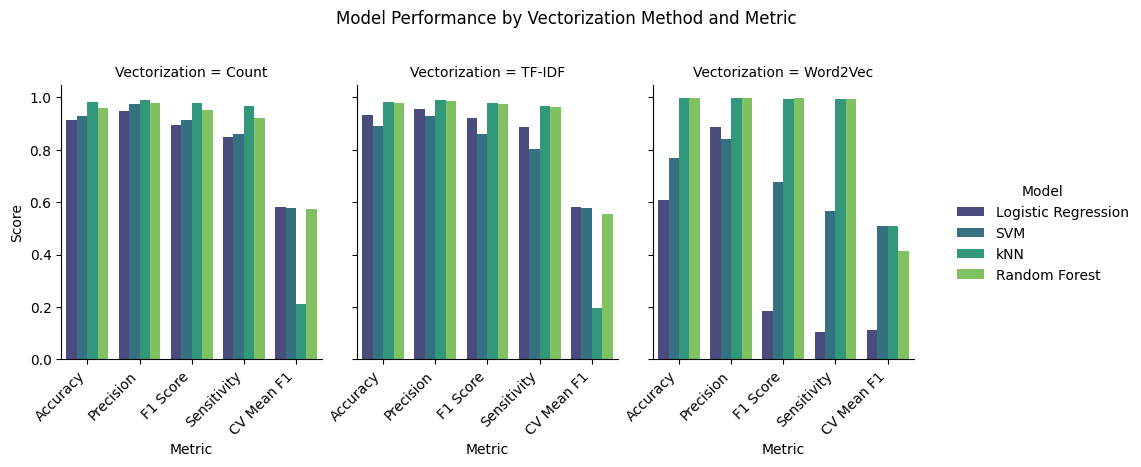

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'results' list is available from the previous cell execution
# If not, you would need to re-run the model training function to get the results list
# For this example, we'll create a dummy results_df based on the output you provided earlier
results_data = {
    'Vectorization': ['Count', 'Count', 'Count', 'Count', 'TF-IDF', 'TF-IDF', 'TF-IDF', 'TF-IDF', 'Word2Vec', 'Word2Vec', 'Word2Vec', 'Word2Vec'],
    'Model': ['Logistic Regression', 'SVM', 'kNN', 'Random Forest', 'Logistic Regression', 'SVM', 'kNN', 'Random Forest', 'Logistic Regression', 'SVM', 'kNN', 'Random Forest'],
    'Accuracy': [0.915539, 0.929857, 0.981216, 0.958492, 0.933666, 0.889268, 0.981085, 0.978983, 0.608827, 0.767766, 0.996322, 0.996585],
    'Precision': [0.948464, 0.973693, 0.989668, 0.980175, 0.956436, 0.928068, 0.989665, 0.986246, 0.888594, 0.841436, 0.996327, 0.997852],
    'F1 Score': [0.896307, 0.913312, 0.977881, 0.950221, 0.919854, 0.861962, 0.977723, 0.975270, 0.183662, 0.676901, 0.995717, 0.996018],
    'Sensitivity': [0.849587, 0.859982, 0.966371, 0.922042, 0.885968, 0.804647, 0.966065, 0.964537, 0.102415, 0.566188, 0.995109, 0.994191],
    'CV Mean F1': [0.580013, 0.579658, 0.212078, 0.572616, 0.580678, 0.579250, 0.194536, 0.554916, 0.113150, 0.509961, 0.508954, 0.414504],
}
results_df = pd.DataFrame(results_data)


# Melt the results_df to have a format suitable for bar plotting
results_melted = results_df.melt(id_vars=['Vectorization', 'Model'],
                                  value_vars=['Accuracy', 'Precision', 'F1 Score', 'Sensitivity', 'CV Mean F1'],
                                  var_name='Metric', value_name='Score')

# Create a bar plot using catplot
g = sns.catplot(x='Metric', y='Score', hue='Model', col='Vectorization', data=results_melted, kind='bar', palette='viridis', col_wrap=3, height=4, aspect=.8)
g.fig.suptitle('Model Performance by Vectorization Method and Metric', y=1.02)
g.tight_layout()

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

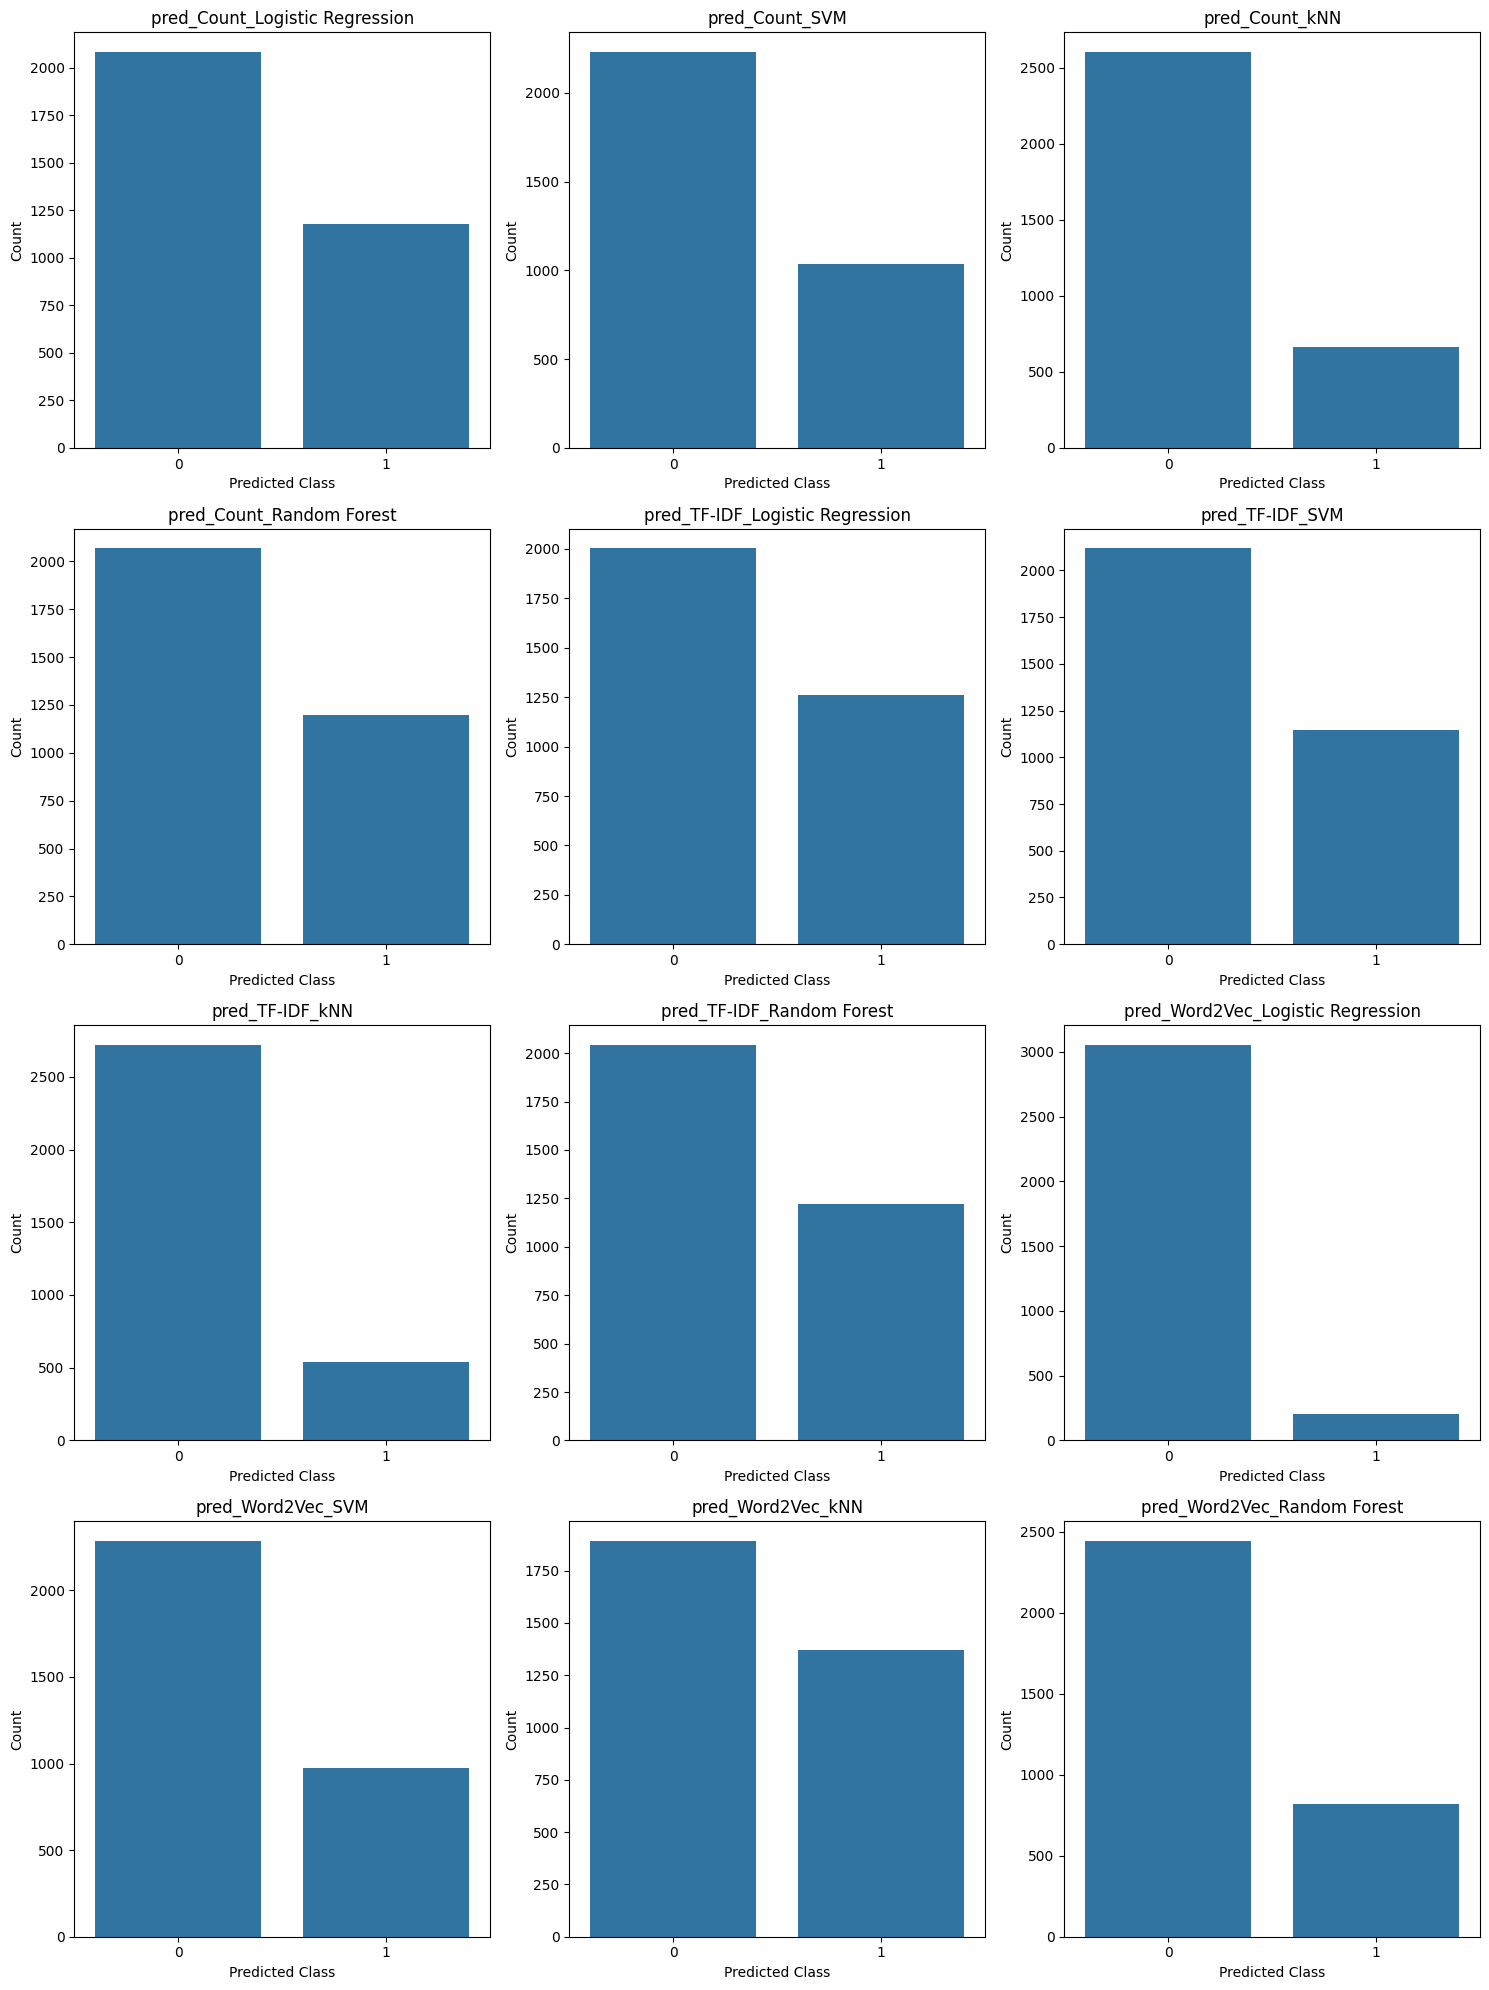

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the test predictions data
test_predictions_df = pd.read_csv('test_predictions.csv')

# Get the prediction columns
prediction_cols = [col for col in test_predictions_df.columns if col.startswith('pred_')]

# Create count plots for each prediction column
fig, axes = plt.subplots(nrows=(len(prediction_cols) + 2) // 3, ncols=3, figsize=(15, 5 * ((len(prediction_cols) + 2) // 3)))
axes = axes.flatten()

for i, col in enumerate(prediction_cols):
    sns.countplot(x=col, data=test_predictions_df, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Predicted Class')
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
def main():
    """
    Main function to run the entire pipeline.
    """
    # Load and preprocess data
    train_df, test_df, X_train, y_train, X_test = load_and_preprocess_data('train.csv', 'test.csv')

    # Vectorize data
    vectorized_data = vectorize_data(X_train, X_test)

    # Get hyperparameter grids
    param_grids = get_param_grids()

    # Train and evaluate models
    results = train_and_evaluate_models(vectorized_data, y_train, param_grids)

    # Create and display results DataFrame
    results_df = pd.DataFrame(results)
    print("\nResults Summary:")
    print(results_df)

    # Find best combination based on CV Mean F1 score
    best_combination = results_df.loc[results_df['CV Mean F1'].idxmax()]
    print(f"\nBest Combination:\n"
          f"Vectorization: {best_combination['Vectorization']}\n"
          f"Model: {best_combination['Model']}\n"
          f"Accuracy: {best_combination['Accuracy']:.4f}\n"
          f"Precision: {best_combination['Precision']:.4f}\n"
          f"F1 Score: {best_combination['F1 Score']:.4f}\n"
          f"Sensitivity: {best_combination['Sensitivity']:.4f}\n"
          f"CV Mean F1: {best_combination['CV Mean F1']:.4f}\n"
          f"CV Std F1: {best_combination['CV Std F1']:.4f}\n"
          f"Best Parameters: {best_combination['Best Params']}")

    # Predict on test set
    predict_test_set(vectorized_data, test_df)

    print("\nTest predictions saved to 'test_predictions.csv'")

if __name__ == "__main__":
    main()

Loading grid search results from 'grid_search_results.pkl'...
Generating hyperparameter effect plots...
Plotting results for Count - Logistic Regression


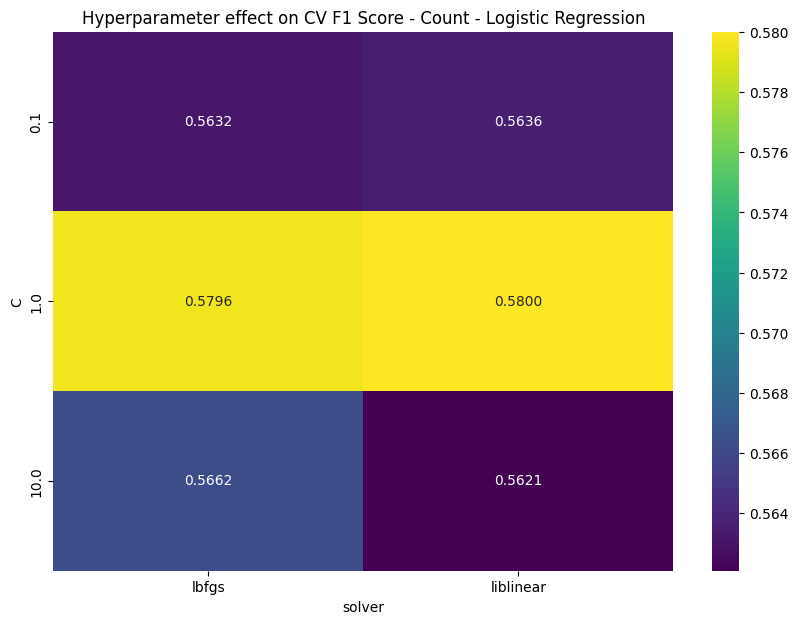

Plotting results for Count - SVM


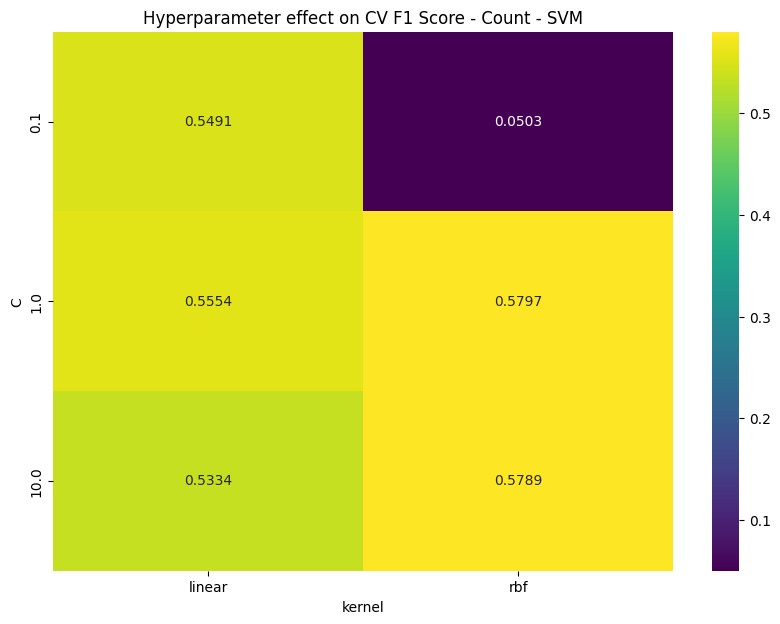

Plotting results for Count - kNN


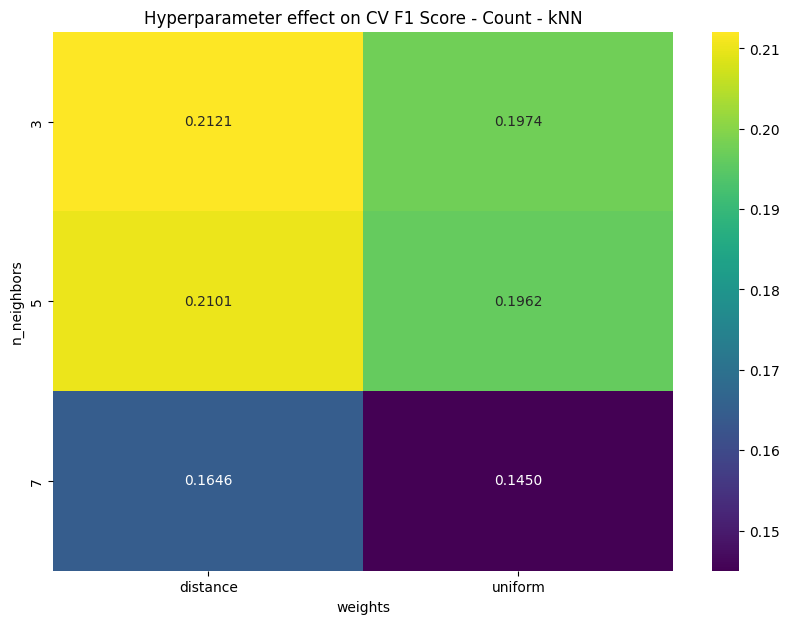

Plotting results for Count - Random Forest
Skipping plotting for Count - Random Forest due to multiple hyperparameters.
Plotting results for TF-IDF - Logistic Regression


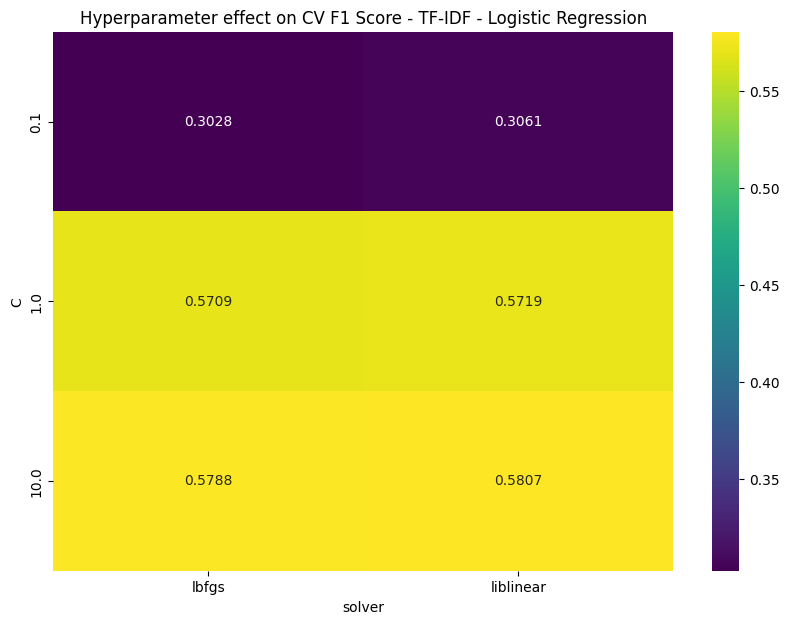

Plotting results for TF-IDF - SVM


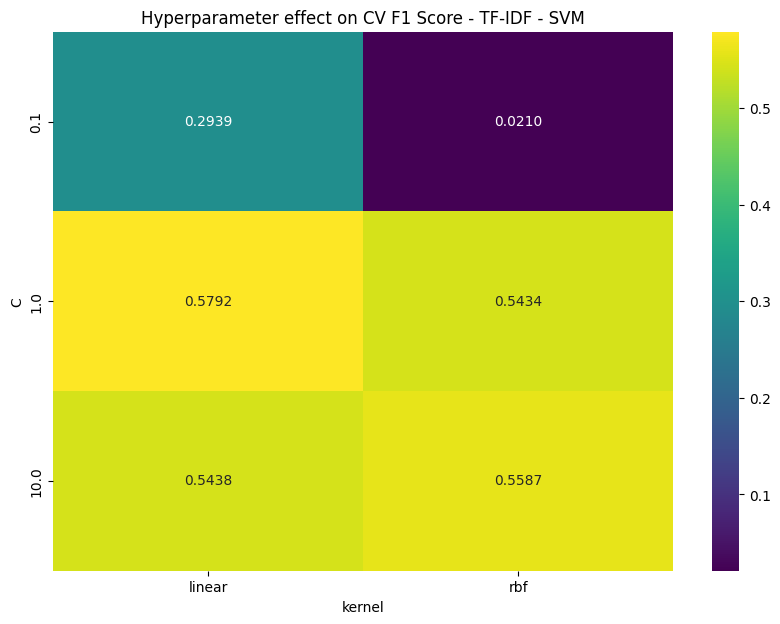

Plotting results for TF-IDF - kNN


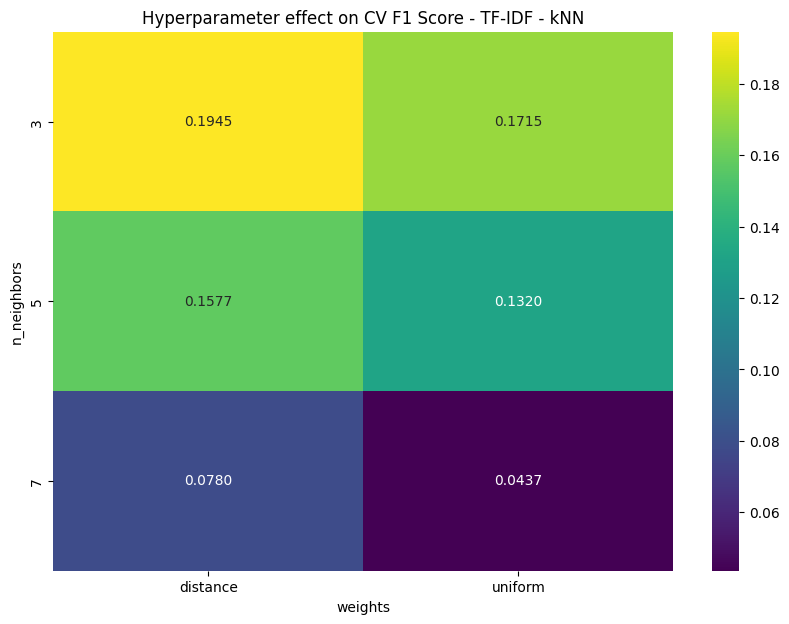

Plotting results for TF-IDF - Random Forest
Skipping plotting for TF-IDF - Random Forest due to multiple hyperparameters.
Plotting results for Word2Vec - Logistic Regression


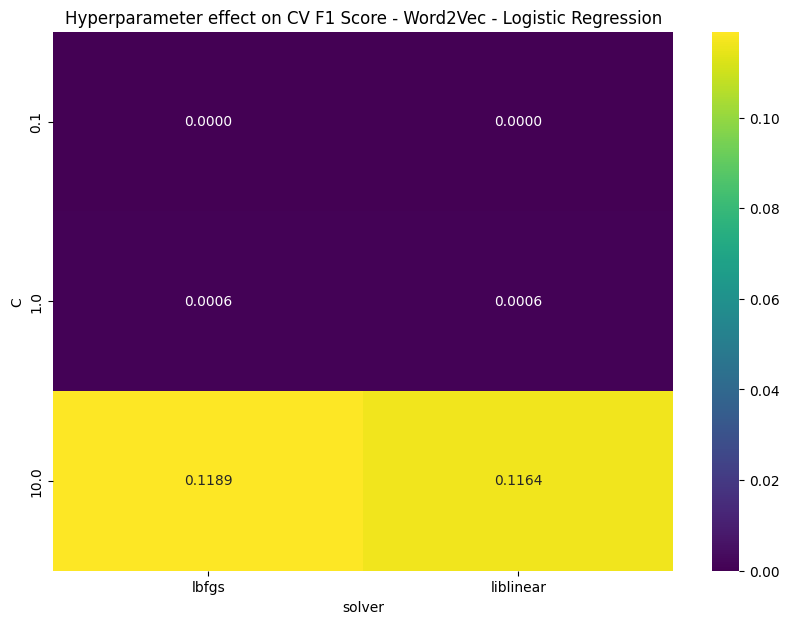

Plotting results for Word2Vec - SVM


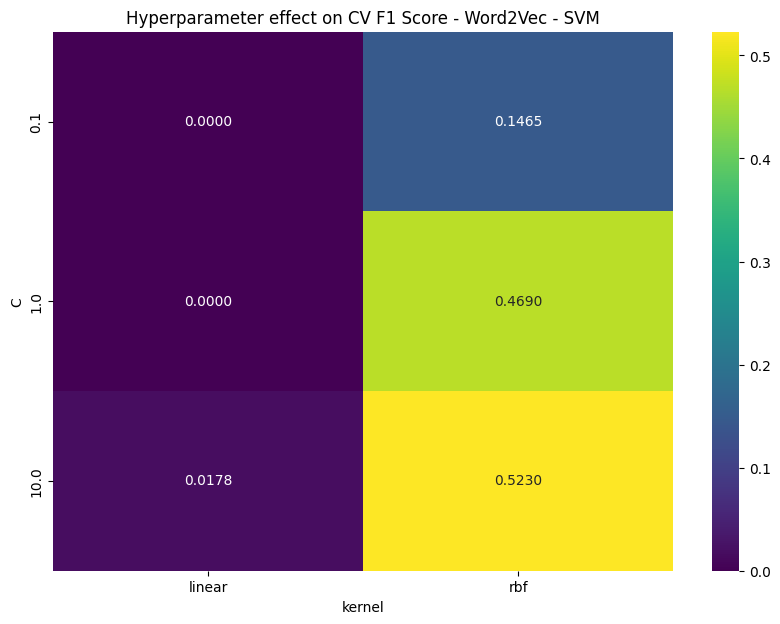

Plotting results for Word2Vec - kNN


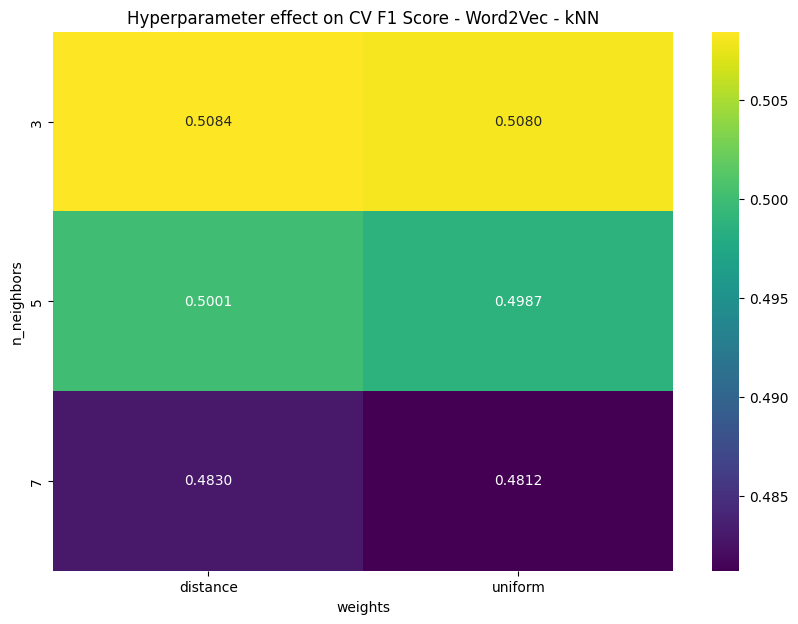

Plotting results for Word2Vec - Random Forest
Skipping plotting for Word2Vec - Random Forest due to multiple hyperparameters.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os

# Load the grid search results from the file
grid_search_results_file = 'grid_search_results.pkl'

if os.path.exists(grid_search_results_file):
    print(f"Loading grid search results from '{grid_search_results_file}'...")
    grid_search_results = joblib.load(grid_search_results_file)

    print("Generating hyperparameter effect plots...")
    for combo_name, cv_results in grid_search_results.items():
        results_df = pd.DataFrame(cv_results)

        model_name = combo_name.split('_')[-1]
        vectorization_method = combo_name.split('_')[0]

        print(f"Plotting results for {vectorization_method} - {model_name}")

        # Get the parameter names
        param_names = [param for param in results_df.columns if param.startswith('param_')]

        # Plotting for models with one or two hyperparameters
        if len(param_names) == 1:
            param_name = param_names[0]
            plt.figure(figsize=(8, 6))
            sns.lineplot(x=param_name, y='mean_test_score', data=results_df)
            plt.title(f'Hyperparameter effect on CV F1 Score - {vectorization_method} - {model_name}')
            plt.xlabel(param_name.replace('param_', ''))
            plt.ylabel('Mean CV F1 Score')
            # Use a try-except block for log scale to handle non-numeric parameter values
            try:
                if pd.api.types.is_numeric_dtype(results_df[param_name]):
                     plt.xscale('log')
            except Exception as e:
                 print(f"Could not set log scale for {param_name}: {e}")
                 pass
            plt.grid(True)
            plt.show()
        elif len(param_names) == 2:
            param1_name = param_names[0]
            param2_name = param_names[1]
            plt.figure(figsize=(10, 7))
            # Create a pivot table for heatmap
            pivot_table = results_df.pivot_table(values='mean_test_score', index=param1_name, columns=param2_name)
            sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".4f")
            plt.title(f'Hyperparameter effect on CV F1 Score - {vectorization_method} - {model_name}')
            plt.xlabel(param2_name.replace('param_', ''))
            plt.ylabel(param1_name.replace('param_', ''))
            plt.show()
        else:
            print(f"Skipping plotting for {vectorization_method} - {model_name} due to multiple hyperparameters.")

else:
    print(f"Grid search results file '{grid_search_results_file}' not found. Please run the model training cell first.")

In [ ]:
import joblib
import pandas as pd

# Load the grid search results from the file
grid_search_results_file = 'grid_search_results.pkl'

if os.path.exists(grid_search_results_file):
    print(f"Loading grid search results from '{grid_search_results_file}'...")
    grid_search_results = joblib.load(grid_search_results_file)

    # Get the results for Word2Vec kNN
    knn_w2v_results = grid_search_results.get('Word2Vec_kNN')

    if knn_w2v_results:
        results_df = pd.DataFrame(knn_w2v_results)

        # Display relevant columns
        print("\nDetailed Grid Search Results for Word2Vec - kNN:")
        display(results_df[['params', 'mean_test_score', 'std_test_score']])
    else:
        print("Results for 'Word2Vec_kNN' not found in the grid search results.")

else:
    print(f"Grid search results file '{grid_search_results_file}' not found. Please run the model training cell first.")

Loading grid search results from 'grid_search_results.pkl'...

Detailed Grid Search Results for Word2Vec - kNN:


,params,mean_test_score,std_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.508042,0.039714
1,"{'n_neighbors': 3, 'weights': 'distance'}",0.508419,0.039845
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.498720,0.042020
3,"{'n_neighbors': 5, 'weights': 'distance'}",0.500096,0.041576
4,"{'n_neighbors': 7, 'weights': 'uniform'}",0.481244,0.051451
5,"{'n_neighbors': 7, 'weights': 'distance'}",0.482971,0.051028


from matplotlib import pyplot as plt
_df_0['mean_test_score'].plot(kind='hist', bins=20, title='mean_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['std_test_score'].plot(kind='hist', bins=20, title='std_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='mean_test_score', y='std_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['mean_test_score'].plot(kind='line', figsize=(8, 4), title='mean_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['std_test_score'].plot(kind='line', figsize=(8, 4), title='std_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)